In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle
import json
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
import numpy as np
import time

import nomad.io.base as loader
import nomad.city_gen as cg
import nomad.traj_gen as tg
from nomad.traj_gen import Agent, Population
from nomad.city_gen import City
from nomad.map_utils import blocks_to_mercator_gdf

import nomad.data as data_folder
from pathlib import Path
data_dir = Path(data_folder.__file__).parent
path = data_dir / "garden_city.gpkg"

In [2]:
traj_df = loader.from_file('sparse_traj_2/part-0.parquet', format='parquet')
diaries_df = loader.from_file('diaries_2/part-0.parquet', format='parquet')
destinations = pd.read_csv('exp_2_destinations_unbalanced.csv')

In [3]:
sample_diary = diaries_df.loc[diaries_df['user_id'] == 'zen_wing']
sample_traj = traj_df.loc[traj_df['user_id'] == 'zen_wing']

In [4]:
from sklearn.neighbors import KernelDensity
import numpy as np
import time

start_time = time.time()

samples = sample_traj[['x', 'y']].values
x, y = samples[:, 0], samples[:, 1]

# --- KDE with scikit-learn ---
kde = KernelDensity(
    kernel='gaussian',
    bandwidth=5        # analogous to your bw_method
).fit(samples)           # note: samples shape (n_samples, 2)

# Build grid over the full traj range
xmin, xmax = sample_traj['x'].min(), sample_traj['x'].max()
ymin, ymax = sample_traj['y'].min(), sample_traj['y'].max()

xx, yy = np.meshgrid(
    np.linspace(xmin, xmax, 500),
    np.linspace(ymin, ymax, 500)
)

# Grid points for evaluation: shape (n_points, 2)
grid_points = np.column_stack([xx.ravel(), yy.ravel()])

# scikit-learn returns log-density
log_dens = kde.score_samples(grid_points)
dens = np.exp(log_dens).reshape(xx.shape)

print("Elapsed:", time.time() - start_time)
print("dens shape:", dens.shape)

Elapsed: 2.2705557346343994
dens shape: (500, 500)


In [5]:
from nomad.stop_detection.viz import plot_pings

Plot saved as test_plot.png
dens shape: (500, 500)
Max density: 0.0016353849481329148
Sample data shape: (183, 2)


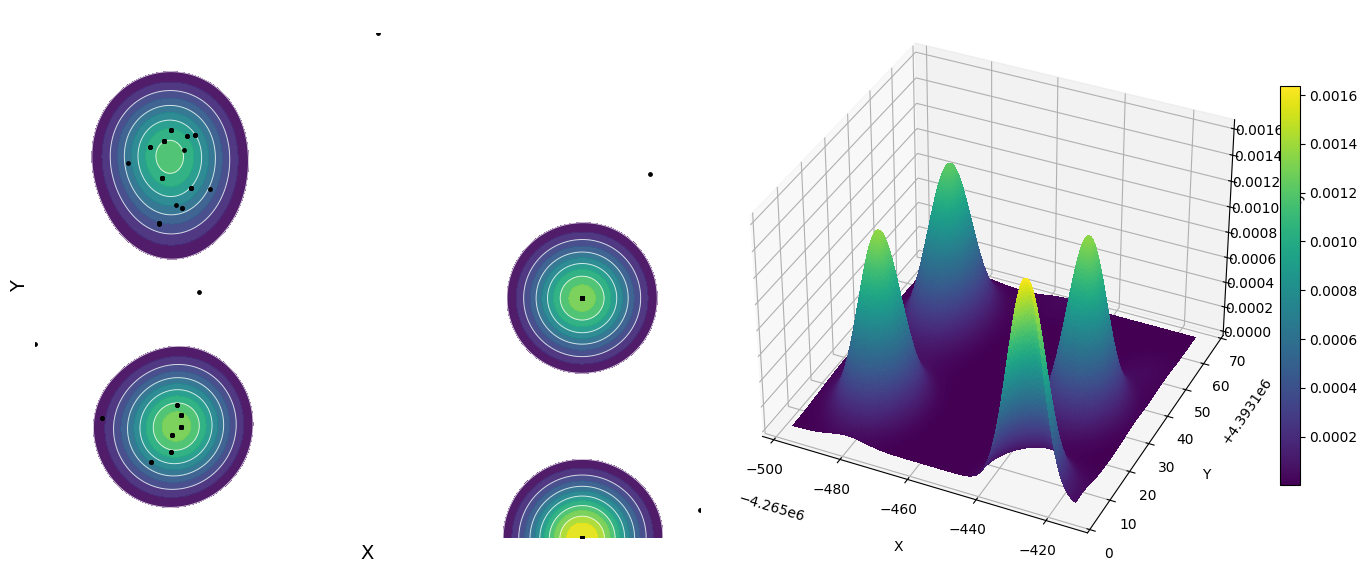

In [6]:
# --------------------- Plotting ---------------------
fig = plt.figure(figsize=(14, 6))

# Left: 2D contours
ax1 = fig.add_subplot(121)
levels = np.linspace(0, dens.max(), 15)[2:]  # <-- changed Z.max() to dens.max()

ax1.contourf(xx, yy, dens, levels=levels, cmap='viridis', alpha=0.95)
ax1.contour(xx, yy, dens, levels=levels[::2], colors='white', linewidths=0.7, alpha=0.8)

ax1.set_xlabel('X', fontsize=14)
ax1.set_ylabel('Y', fontsize=14)
ax1.set_aspect('equal')

plot_pings(sample_traj, ax1)

# Right: 3D surface
ax2 = fig.add_subplot(122, projection='3d')
surf = ax2.plot_surface(
    xx, yy, dens,
    cmap='viridis',
    linewidth=0,
    antialiased=False,
    alpha=0.98,
    rcount=300,
    ccount=300
)

ax2.set_xlabel('X', labelpad=10)
ax2.set_ylabel('Y', labelpad=10)
ax2.set_zlabel('Density', labelpad=10)

ax2.view_init(elev=35, azim=-65)

# Colorbar
m = plt.cm.ScalarMappable(cmap='viridis')
m.set_array(dens)   # <-- changed from Z

fig.colorbar(m, ax=ax2, shrink=0.7, aspect=20, pad=0.02)

plt.tight_layout()
plt.savefig("test_plot.png")

print("Plot saved as test_plot.png")
print("dens shape:", dens.shape)
print("Max density:", np.max(dens))
print("Sample data shape:", samples.shape)

In [9]:
city_file = data_dir / "garden-city.gpkg"
city = cg.City.from_geopackage(city_file)

In [14]:
import nomad.map_utils as mu
# buildings = mu.blocks_to_mercator_gdf(city.buildings_gdf, block_size=15,false_easting=-4265699.0, false_northing=4392976.0)
# buildings.plot(column='building_type')
# plot_pings(sample_traj, ax1)

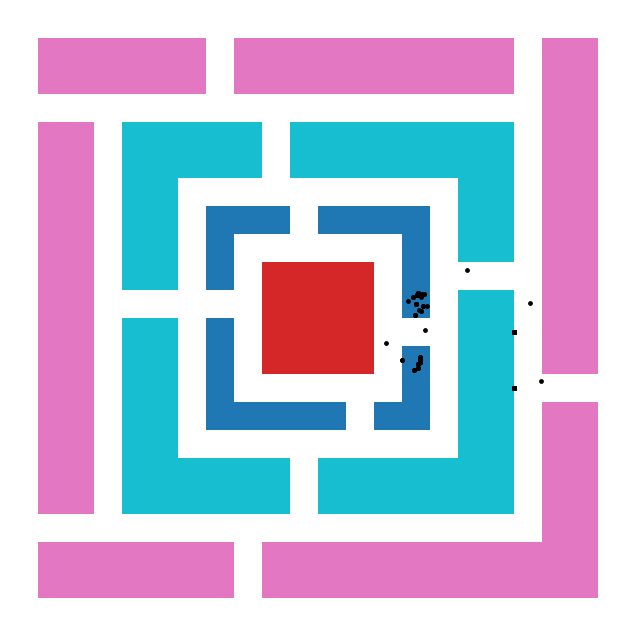

In [15]:
fig, ax1 = plt.subplots(figsize=(10, 8))

buildings = mu.blocks_to_mercator_gdf(city.buildings_gdf, block_size=15,false_easting=-4265699.0, false_northing=4392976.0)
buildings.plot(column='building_type', ax=ax1)
plot_pings(sample_traj, ax1)

ax1.set_aspect('equal')
plt.show()